In [1]:
import pandas as pd
import numpy as np


In [7]:
trade_bra = pd.read_csv('data/econ_data/trade_bra.csv', dtype = {'HS ID 4': str}).dropna(subset = ['Exports', 'Imports'])
wages_bra = pd.read_csv('data/econ_data/wages_bra.csv').dropna(subset = ['Total Jobs', 'Total Yearly Wages'])
trade_chi = pd.read_csv('data/econ_data/trade_chi.csv', dtype = {'HS ID 4': str})
prod_chi = pd.read_csv('data/econ_data/wages_output_chi.csv')#.dropna(subset = ['Total Jobs', 'Total Yearly Wages'])

data_bugs = list(trade_chi.loc[trade_chi['HS ID 6'].str[-1] == ','].index)
trade_chi = trade_chi.drop(data_bugs)

## Info of aggregations

In [4]:
# Load info
path = 'data/disagg_struct_refs/formatted/'

CIIU = pd.read_csv(path+'CIIU_full.csv')
CBO = pd.read_csv(path+'CBO_full.csv').astype(str)
CNAE = pd.read_csv(path+'CNAE_full.csv').astype(str)
HS = pd.read_csv(path+'hs_full.csv').astype(str)

#Geographic info

geo_ids = pd.concat([wages_bra['BRA ID MIR'], trade_bra['BRA ID MIR']]).unique()
GEO_bra = pd.DataFrame([[gid[:3],gid[:5],gid]  for gid in geo_ids], columns = ['BRA ID ST', 'BRA ID MER', 'BRA ID MIR'])
GEO_bra.to_csv('data/disagg_struct_refs/formatted/GEO_bra.csv', index = False)

GEO_chi = pd.read_csv(path+'GEO_chi.csv')[['reg_id', 'prov_id', 'comuna_id']]
GEO_chi = GEO_chi.rename({'reg_id':'CHI ID REG', 'prov_id':'CHI ID PRO', 'comuna_id':'CHI ID COM'},axis = 1)


In [5]:
# year = 2011

df_list = []
for year in [2011, 2012, 2013, 2014]:
    trade_bra = trade_bra.loc[trade_bra.Year == year].drop('Year', axis = 1, errors = 'ignore')
    wages_bra = trade_bra.loc[trade_bra.Year == year].drop('Year', axis = 1, errors = 'ignore')


    Geo_lev = 'MER'
    trade_bra = trade_bra.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'HS ID 4']).sum().reset_index()
    wages_bra = wages_bra.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID F']).sum().reset_index()

    # Bring 3 datasets and give them node_names. Prepare for correlation

    x = wages_bra.merge(CBO_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID GG']).sum()[['Total Yearly Wages']].reset_index()
    x = x.merge(CNAE_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID S', 'CBO ID GG']).sum()[['Total Yearly Wages']].reset_index()

    # use label for naming nodes
#     x_ = x.merge(CNAE[['CNAE ID S','CNAE label S']].drop_duplicates())
#     x_ = x_.merge(CBO[['CBO ID GG', 'CBO label GG']].drop_duplicates())
#     x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'label' in col]].apply(' of '.join, axis=1)

    # use ID for naming nodes
    x_ = x
    x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'ID' in col and 'BRA' not in col]].apply(' of '.join, axis=1)
    
    x_ = x_.drop([col for col in x_.columns if 'label' in col], axis = 1)

    x = x_

    x = x.rename({'CNAE ID S': 'att_A', 'CBO ID GG': 'att_B', 'Total Yearly Wages': 'value_USD'}, axis = 1)


    # Trade in HS2
    y = trade_bra.merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID 2']).sum().reset_index()

    y_ = y.merge(HS[['HS ID 2','HS label 2']].drop_duplicates())
    y_['node_name'] = 'Exports of ' + y_[[col for col in y_.columns if 'label' in col]].apply(' of '.join, axis=1)
    y_ = y_.drop([col for col in y_.columns if 'label' in col], axis = 1)
    y = y_
    y = y.rename({'HS ID 2': 'att_A', 'Exports': 'value_USD'}, axis = 1)
    y['att_B'] = y['att_A']

    z = trade_bra.merge(GEO_bra).merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID 2']).sum().reset_index()

    z_ = z.merge(HS[['HS ID 2','HS label 2']].drop_duplicates())
    z_['node_name'] = 'Imports of ' + z_[[col for col in z_.columns if 'label' in col]].apply(' of '.join, axis=1)
    z_ = z_.drop([col for col in z_.columns if 'label' in col], axis = 1)
    z = z_
    z = z.rename({'HS ID 2': 'att_A', 'Imports': 'value_USD'}, axis = 1)
    z['att_B'] = z['att_A']


    #Save nodes info
    nodes_df = pd.concat([x, y, z]).groupby('node_name').first()[['att_A', 'att_B']]

    #Data for correlation
    df = pd.concat([x, y, z]).groupby(['BRA ID '+Geo_lev, 'node_name']).sum()[['value_USD']]
    # functions.drop_small_cats(concat_data, .95)
    df = df.unstack()
    df.columns = df.columns.droplevel(0)


    # correlations
    robust_th = 8
    corr_geolevel_yr = np.log10(df).corr(min_periods = robust_th)
    del corr_geolevel_yr.index.name
    del corr_geolevel_yr.columns.name

    df_list += [pd.DataFrame(corr_geolevel_yr.stack(), columns = ['corr_'+str(year)+'_'+Geo_lev+'_S_GG_2_2'])]
    
    print 'done year '+ str(year)

AttributeError: 'DataFrame' object has no attribute 'Year'

In [77]:
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2', index = False)
pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2_i')

In [75]:
df = pd.read_csv('data/Corr/corr_MER_S_GG_2_2')

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

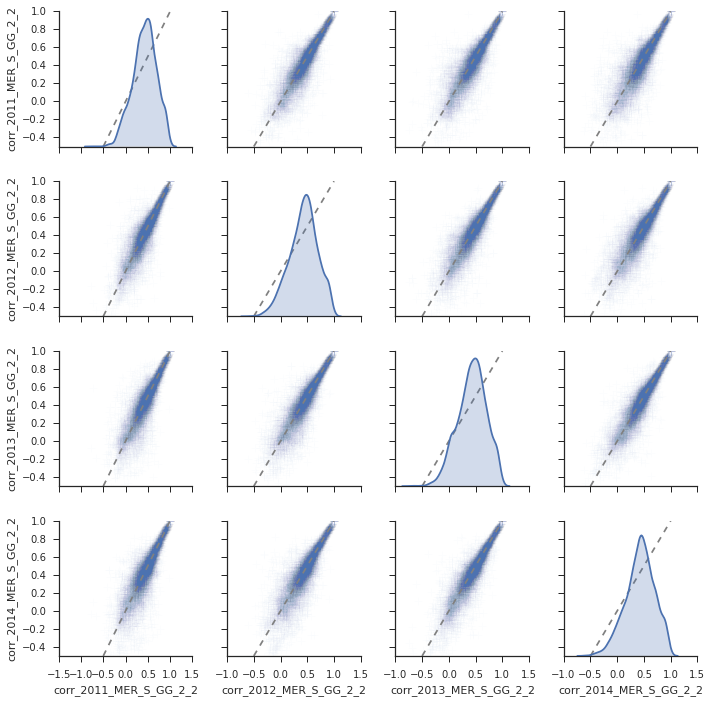

In [101]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
pp = sns.pairplot(df.sample(10000).dropna(), diag_kind="kde", markers="+",
             plot_kws=dict(s=50, edgecolor="b", linewidth=1, alpha = .01),
             diag_kws=dict(shade=True))
[[ax.set_ylim(-.5,1) for ax in ax_list] for ax_list in pp.axes]
x = [-.5, 1]
[[pp.axes[i][j].plot(x,x, c = '.5', linestyle = '--') for i in range(3) if j != i]for j in range(3)]


plt.show()